In [147]:
# import required libaries
import os
import hs_utils
import numpy as np
from datetime import datetime
import itertools as it
import matplotlib.pyplot as plt
%matplotlib inline

In [148]:
# establish a secure connection to HydroShare
hs = hs_utils.hydroshare()

Adding the following system variables:
   HS_USR_NAME = TonyCastronova
   HS_RES_ID = 25040a158eac4730b31eb5ebcc3a7339
   HS_RES_TYPE = genericresource
   JUPYTER_HUB_IP = jupyter.uwrl.usu.edu

These can be accessed using the following command: 
   os.environ[key]

   (e.g.)
   os.environ["HS_USR_NAME"]  => TonyCastronova


In [149]:
# get some resource content. The resource content is returned as a dictionary
content = hs.getResourceFromHydroShare('927094481da54af38ffb6f0c39ad8787')

This resource already exists in your userspace.  Would you like to overwrite this data [Y/n]? Y
                      


BeaverDivideTemp.csv,/home/jovyan/work/notebooks/data/927094481da54af38ffb6f0c39ad8787/927094481da54af38ffb6f0c39ad8787/data/contents/BeaverDivideTemp.csv


In [150]:
# preview the content of the BeaverDivideTemp file
air_temp_csv = hs.content['BeaverDivideTemp.csv']
with open(hs.content['BeaverDivideTemp.csv']) as f:
    for i in range(0, 10):
        print(f.readline())

# Date, Air Temperature degC

10-30-2013 10:15:00, 20.91 

10-30-2013 12:00:00, 21.62 

10-30-2013 12:15:00, 21.87 

10-30-2013 12:30:00, 21.92 

10-31-2013 09:15:00, -174.4 

10-31-2013 09:30:00, -9999 

10-31-2013 09:45:00, -9999 

10-31-2013 10:30:00, -2.693 

10-31-2013 10:30:00, -2.693 



In [152]:
# read all of the data into a numpy array
data = np.genfromtxt(air_temp_csv,comments='#', delimiter=',',autostrip=True,
                    converters={0: lambda x: datetime.strptime(x.decode("utf-8"), 
                                                               '%m-%d-%Y %H:%M:%S')})

In [153]:
# group the temperature data by day
start = data[0][0]
lenperiod = 1

# lists to hold the grouped temperatures and dates
grouped_data = []
grouped_dates = []

ind = 0
for k, g in it.groupby(data,lambda data: (data[0]-start).days // lenperiod):
    group = list(g)
    grouped_dates.append(group[0][0])
    d = [g[1] for g in group if g[1] != -9999]
    grouped_data.append(d)
    

In [154]:
# calculate min, max, and average temperatures

# initialize the t_min, t_max, and t_ave arrays
t_min = np.full((len(grouped_dates), 1),  9999, dtype=np.float)
t_max = np.full((len(grouped_dates), 1), -9999, dtype=np.float)
t_ave = np.full((len(grouped_dates), 1), 0, dtype=np.float)

# loop over every day
for i in range(len(grouped_dates)):
    temp_count = 0
    # loop over each recorded temperature 
    for temp in grouped_data[i]:        
        # skip nodata values and any value less than -80 C
        if temp > -80:
            # save the min temp
            if temp < t_min[i]:
                t_min[i] = temp
            # save the max temp
            if temp > t_max[i]:
                t_max[i] = temp
            # sum the temps
            t_ave[i] += temp
            temp_count += 1
    # calculate the average temp
    t_ave[i] = (t_ave[i] / temp_count).round(2)
        

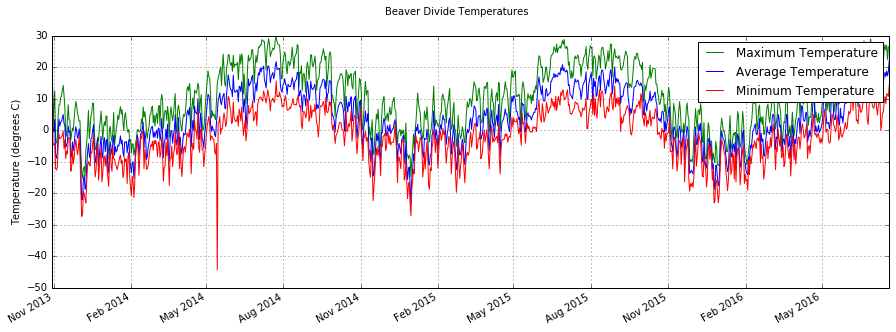

In [155]:
# visualize the calculated temperature data 

# create a figure
fig, ax = plt.subplots(1,1,figsize=(15, 5))

# plot each temperature time series
tmax = ax.plot_date(grouped_dates, t_max, 'g-', label='Maximum Temperature')
tave = ax.plot_date(grouped_dates, t_ave, 'b-', label='Average Temperature')
tmin = ax.plot_date(grouped_dates, t_min, 'r-', label='Minimum Temperature')

# display a legend
h, l = ax.get_legend_handles_labels()
ax.legend(h, l)

# set the figure title
fig.suptitle('Beaver Divide Temperatures')
plt.ylabel('Temperature (degrees C)')

# format the ticks
ax.grid(True)
fig.autofmt_xdate()

In [156]:
# set the save path for the aggregated values
temp_agg = os.path.join(os.environ['DATA'], 'beaver_divide_temp_daily_agg.csv')

# write the derived temperatures to a csv file
with open(temp_agg, 'w') as f:
    f.write('Date, Ave Temp (C), Min Temp (C), Max Temp (C)\n')
    for i in range(len(grouped_dates)):
        f.write('%s,%3.2f,%3.2f,%3.2f\n' % 
               (grouped_dates[i].strftime('%m-%d-%Y'), t_ave[i], t_min[i], t_max[i]))
        

In [157]:
# define HydroShare required metadata
title = 'Daily Aggregate Temperature for Beaver Divide'
abstract = 'This daily average air temperature for the Beaver Divide gauging station that is maintained by iUtah researchers.'
keywords = ['Temperatire', 'Beaver Divide', 'Time Series']

# set the resource type that will be created.
rtype = 'genericresource'

# create a list of files that will be added to the HydroShare resource.
files = [temp_agg]  

# Set the Beaver Divide temperature resource as the "parent" 
# (i.e. the new resource will be "derived from" the "927094481da54af38ffb6f0c39ad8787 resource)
parent_resource = '927094481da54af38ffb6f0c39ad8787'


In [ ]:
# create a hydroshare resource containing these data
resource_id = hs.createHydroShareResource(abstract, 
                                          title, 
                                          derivedFromId=parent_resource,
                                          keywords=keywords, 
                                          resource_type=rtype, 
                                          content_files=files, 
                                          public=False)